# Итоговый проект по дисциплине "Алгоритмы и структуры данных"



# 1. Импорт библиотек и подготовка изображений

In [4]:
import numpy as np
from math import exp, pi
from numpy.fft import fft2, fftshift
from random import randint
from scipy.signal import convolve2d
import skimage
from skimage import img_as_float, img_as_ubyte
from skimage.io import imread, imshow
from skimage.color import rgb2gray
import cv2

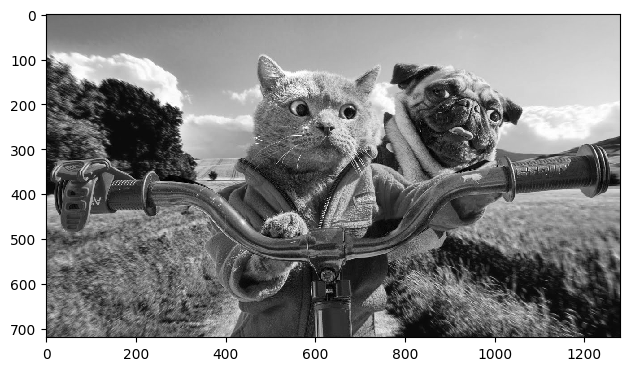

In [5]:
img = imread('https://i.ytimg.com/vi/o1YA_6tXs5E/maxresdefault.jpg')
img = skimage.color.rgb2gray(img)
imshow(img)

# 2. Построение гауссовской пирамиды

Функция для вычислеядра гауссовского фильтра

In [6]:
def gauss_filter(g, x, y):
  result = 1/(2*pi*g**2) * exp((-x**2-y**2)/(2*g**2))
  return result
    
def get_kernel(g):
  r = round(3*g)
  k = int(round(g*6)+1)
  kernel = np.array([[0.0]*k]*k)
  sum = 0
  for x in range(len(kernel)):
    for y in range(len(kernel)):
      kernel[x, y] = gauss_filter(g, x-len(kernel)//2, y-len(kernel)//2)
      sum += kernel[x, y] 
  for x in range(len(kernel)):
    for y in range(len(kernel)):
      kernel[x, y] /= sum
  return k, kernel   

Функция для построения гауссовской пирамиды. Операция свертки выполняется с помощью функции convolve2d
(режим 'same' используется для сохранения размера исходного изображения)

In [7]:
def get_gauss_pyramid(img, sigma, n_layers):
  k, kernel = get_kernel(sigma)
  new_images = []
  layer = img_as_float(img)
  for _ in range(n_layers):
    temp = convolve2d(layer, kernel, mode='same')
    new_images.append(temp)
    layer = new_images[-1]
  return new_images

Функция для представления амплитуды частот изображений пирамиды

In [8]:
def freq(img):
  imshow(np.round(np.log(1 + np.abs(fftshift(fft2(img))))).astype('uint8'), cmap='gray')

Посмотрим на результаты работы функции с различными значениями σ. Для начала возьмём σ со значением 1. Первый
слой:

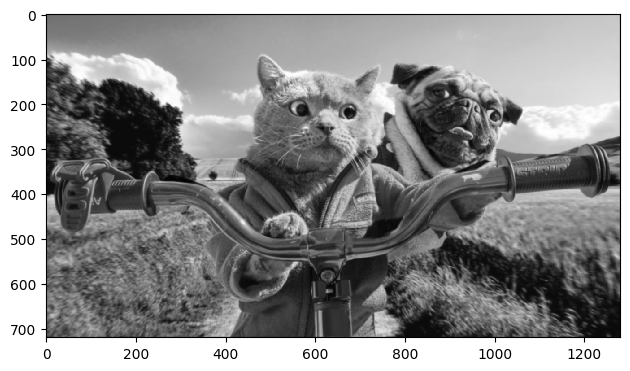

In [9]:
result = get_gauss_pyramid(img, 1, 5)
imshow(result[0])

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


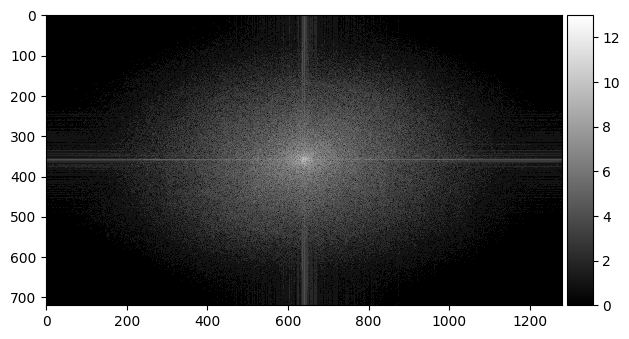

In [10]:
freq(result[0])

Второй слой:

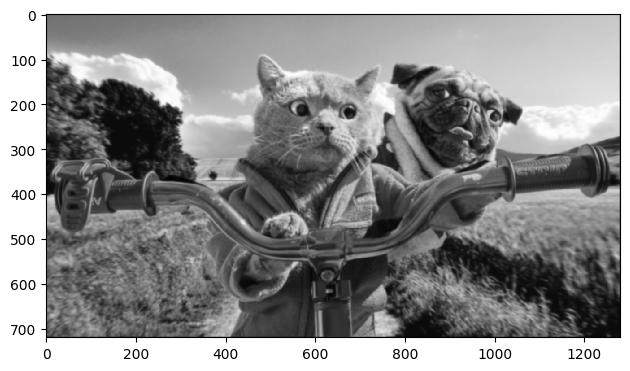

In [11]:
imshow(result[1])

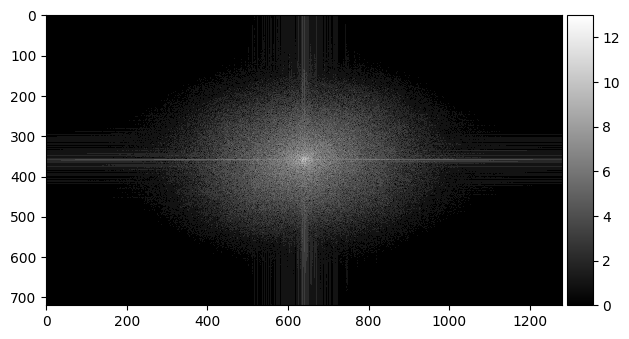

In [12]:
freq(result[1])

Третий слой:

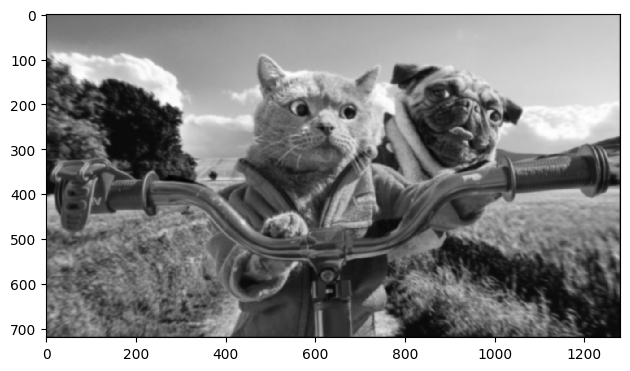

In [13]:
imshow(result[2])

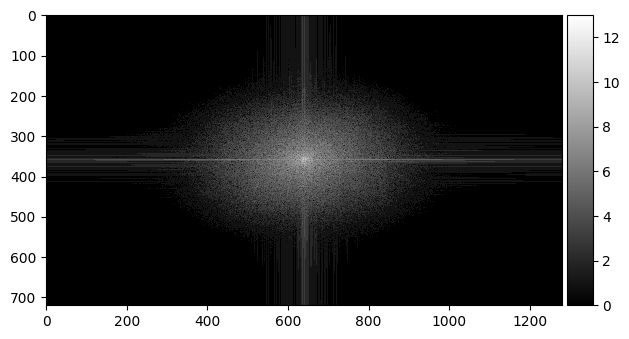

In [14]:
freq(result[2])

Четвертый слой:

In [15]:
imshow(result[3])

In [16]:
freq(result[3])

Пятый слой:

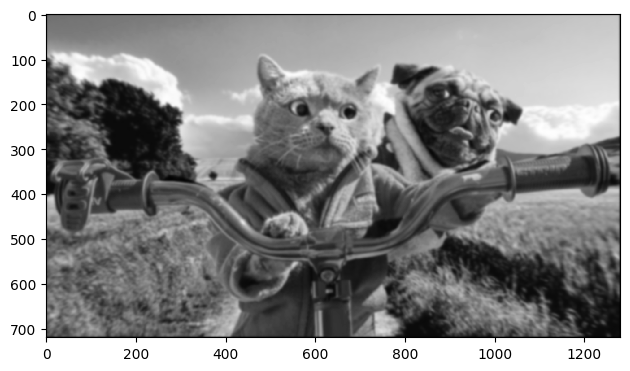

In [17]:
imshow(result[4])

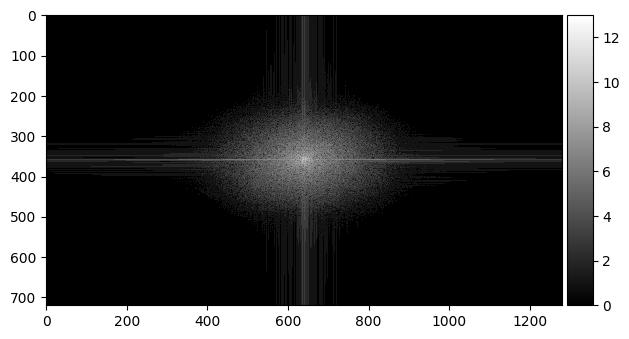

In [18]:
freq(result[4])

Как видно, с каждым слоем картинка все более размыта

Посмотрим на изображения при σ = 2 (первый слой):

In [19]:
result2 = get_gauss_pyramid(img, 2, 5)
imshow(result2[0])

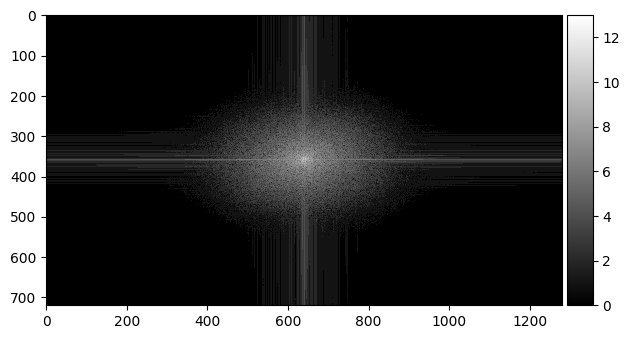

In [20]:
freq(result2[0])

Теперь пятый слой:

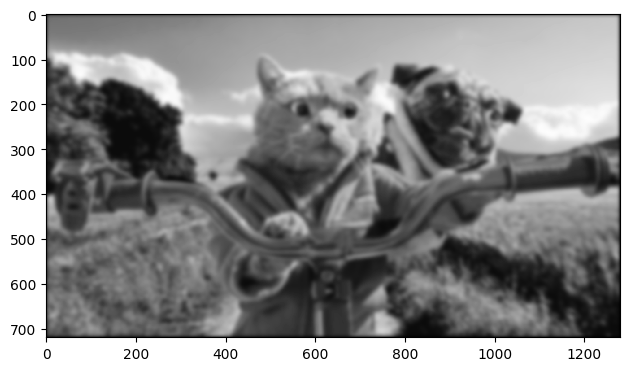

In [21]:
imshow(result2[4])

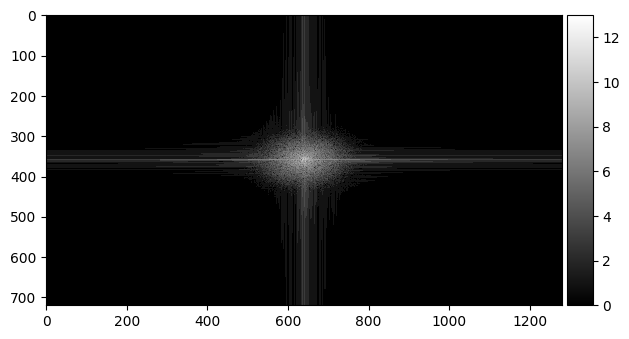

In [22]:
freq(result2[4])

Посмотрим на изображения при σ = 3 (первый слой):

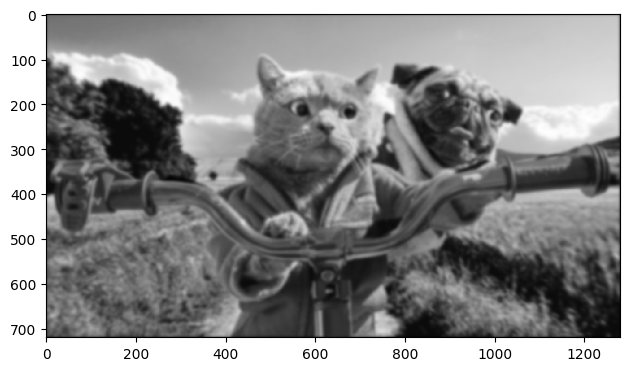

In [23]:
result3 = get_gauss_pyramid(img, 3, 5)
imshow(result3[0])

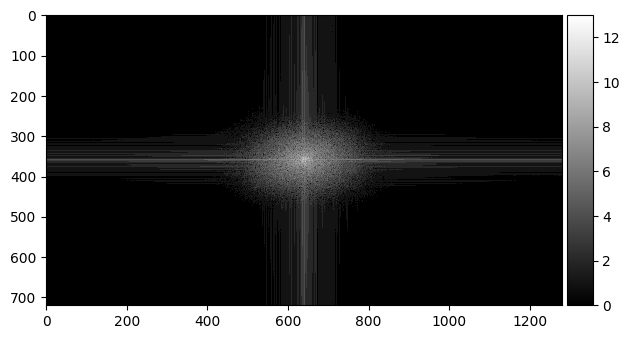

In [24]:
freq(result3[0])

Пятый слой:

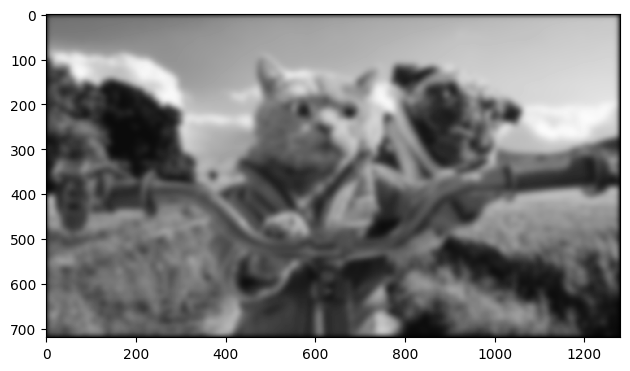

In [25]:
imshow(result3[4])

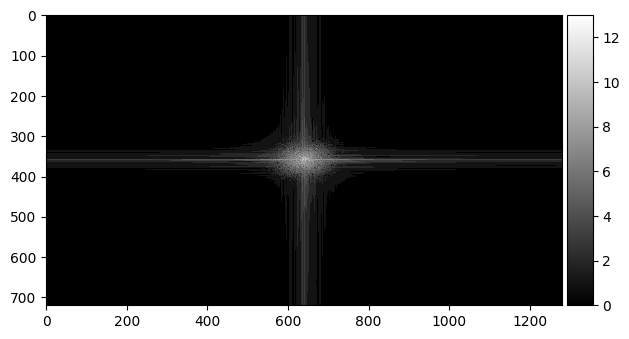

In [26]:
freq(result3[4])

Заметим, что при увеличении σ сильнее размывается изображение и быстрее сужается диапазон частот

# 3. Построение лапласовской пирамиды

In [27]:
def get_laplace_pyramid(img, sigma, n_layers):
  gauss_images = get_gauss_pyramid(img, sigma, n_layers)
  new_images = []
  temp = img_as_float(img)
  layer = gauss_images[0]
  for i in range(len(gauss_images)-1):
    new_images.append(temp-layer)
    temp = layer
    layer = gauss_images[i+1]
  new_images.append(gauss_images[-1])
  return new_images

Посмотрим на результаты работы функции с различными значениями σ. 
Для начала возьмём σ=1 (первый
слой):

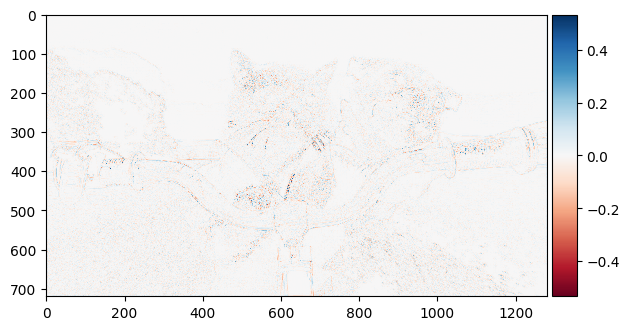

In [28]:
res = get_laplace_pyramid(img, 1, 5)
imshow(res[0])

In [29]:
freq(res[0])

Пятый слой:

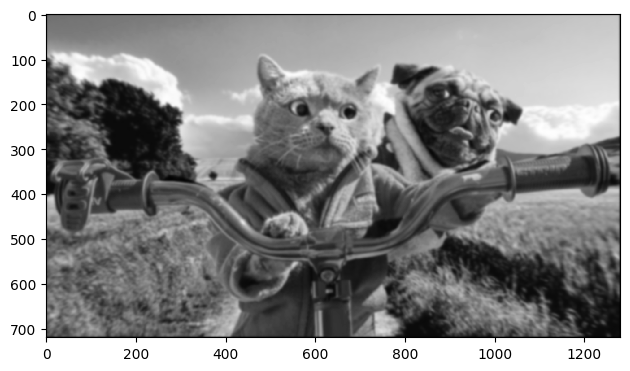

In [30]:
imshow(res[4])

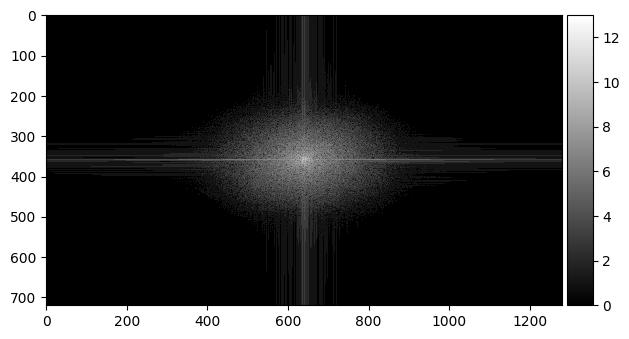

In [31]:
freq(res[4])

Возьмем σ = 2 (первый слой):



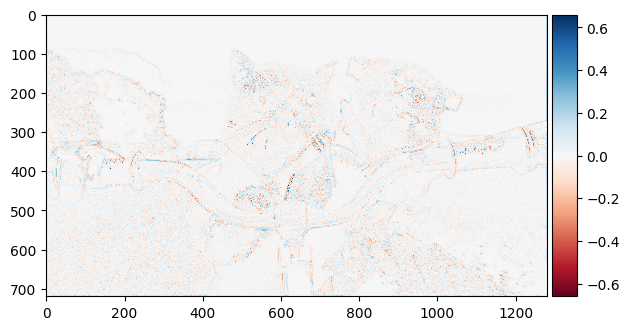

In [32]:
res2 = get_laplace_pyramid(img, 2, 5)
imshow(res2[0])

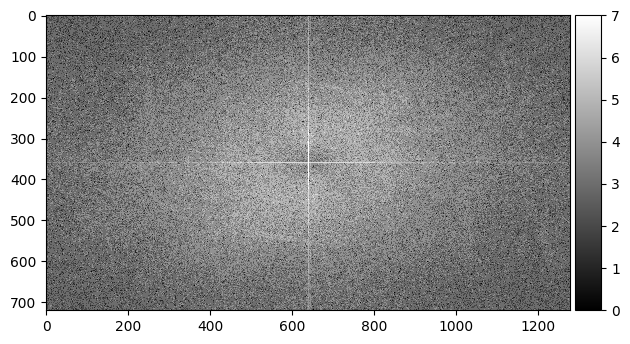

In [33]:
freq(res2[0])

Пятый слой:

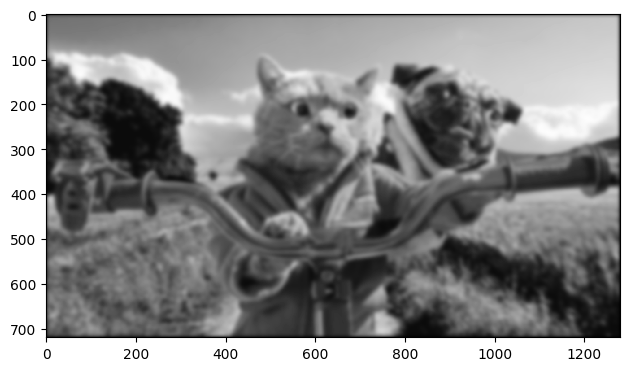

In [34]:
imshow(res2[4])

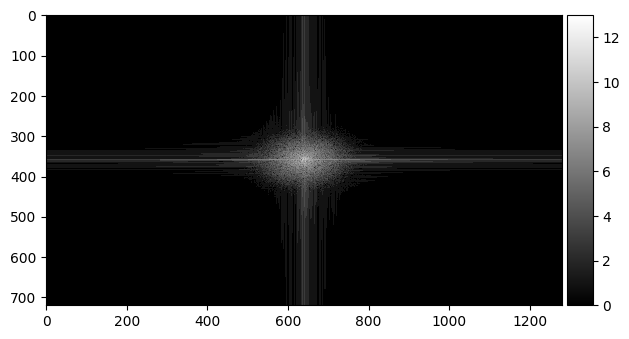

In [35]:
freq(res2[4])

Возьмем σ = 3 (первый слой):

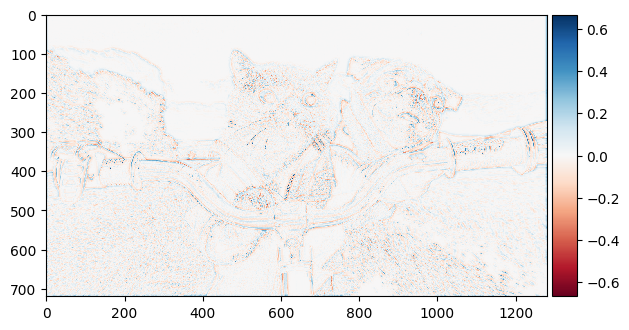

In [36]:
res3 = get_laplace_pyramid(img, 3, 5)
imshow(res3[0])

In [37]:
freq(res3[0])

Пятый слой:

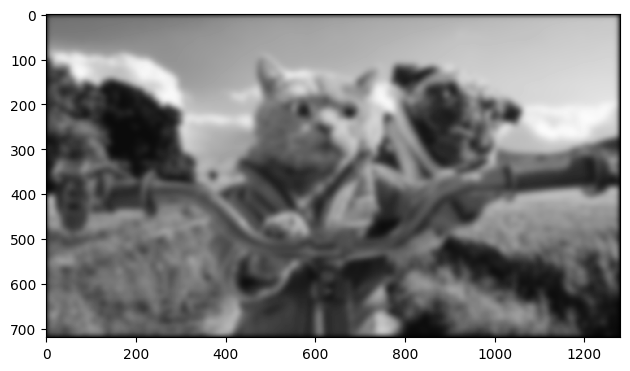

In [38]:
imshow(res3[4])

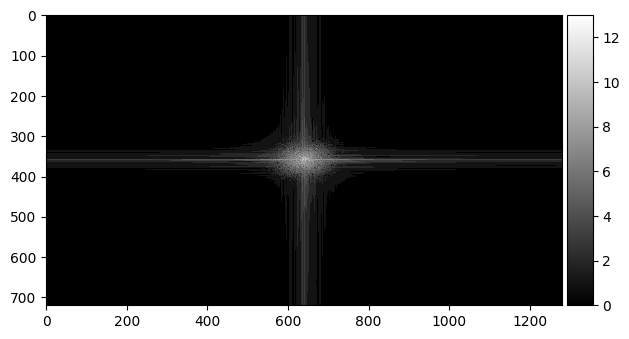

In [39]:
freq(res3[4])

# 4. Склейка изображений

Загрузим изображения для тестирования:

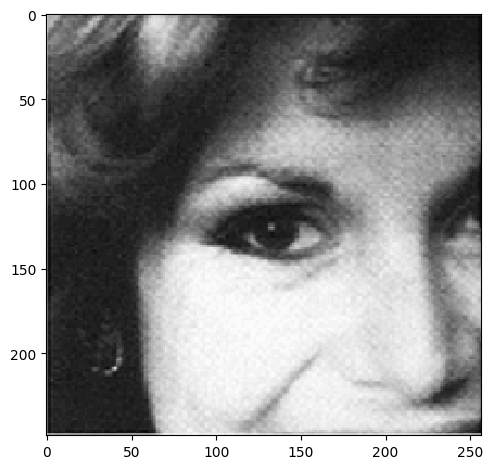

In [40]:
img1 = rgb2gray(imread('https://stepik.org/media/attachments/lesson/58410/a.png'))
imshow(img1)

In [41]:
img2 = rgb2gray(imread('https://stepik.org/media/attachments/lesson/58410/b.png'))
imshow(img2)

In [42]:
mask = rgb2gray(imread('https://stepik.org/media/attachments/lesson/58410/mask.png'))
imshow(mask)

Функция для склейки изображений

In [43]:
def merge(img1, img2, mask, sigma, n_layers):
  img1_lap = get_laplace_pyramid(img1, sigma, n_layers)
  img1_lap.reverse()
  mask_gauss = get_gauss_pyramid(mask, sigma, n_layers)
  mask_gauss.reverse()
  img2_lap = get_laplace_pyramid(img2, sigma, n_layers)
  img2_lap.reverse()
  arr = np.array([0]*mask_gauss[0])
  for i in range(len(mask_gauss)):
    arr += img1_lap[i] * mask_gauss[i] + img2_lap[i] * (1 - mask_gauss[i])
  return arr

Посмотрим на результат работы функции при различных σ:

 σ = 1

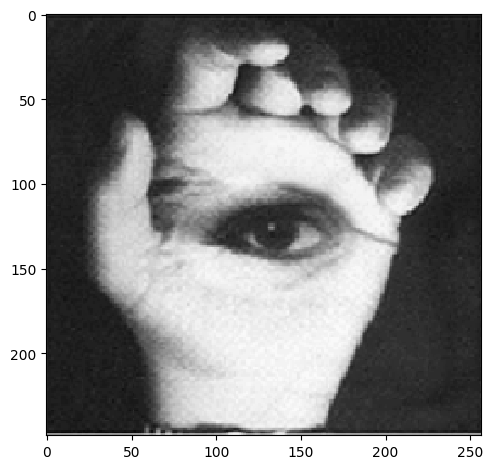

In [44]:
img_out = img_as_ubyte(np.clip(merge(img1, img2, mask, 1, 5), -1, 1))
imshow(img_out)

σ = 2

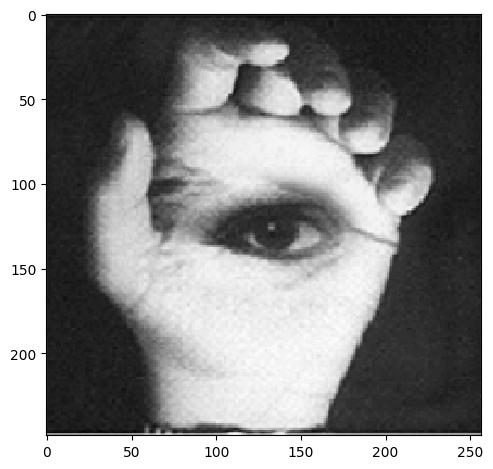

In [45]:
img_out = img_as_ubyte(np.clip(merge(img1, img2, mask, 2, 5), -1, 1))
imshow(img_out)

σ = 3

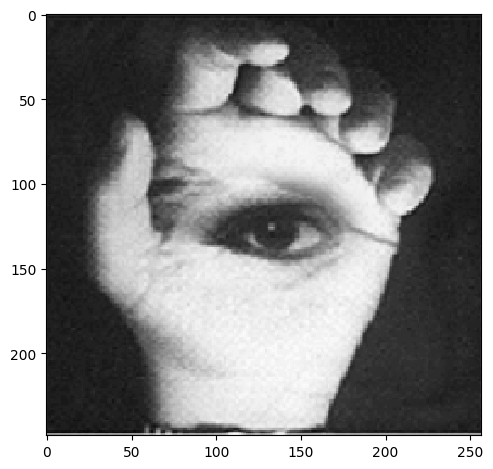

In [46]:
img_out = img_as_ubyte(np.clip(merge(img1, img2, mask, 3, 5), -1, 1))
imshow(img_out)

Теперь изменим количество слоёв при σ = 1:

Первый слой:

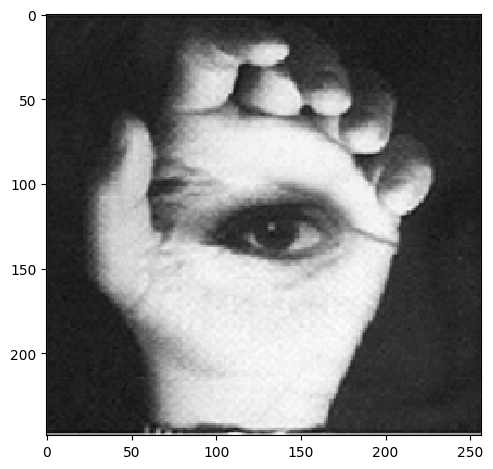

In [47]:
img_out = img_as_ubyte(np.clip(merge(img1, img2, mask, 1, 10), -1, 1))
imshow(img_out)

Второй слой:

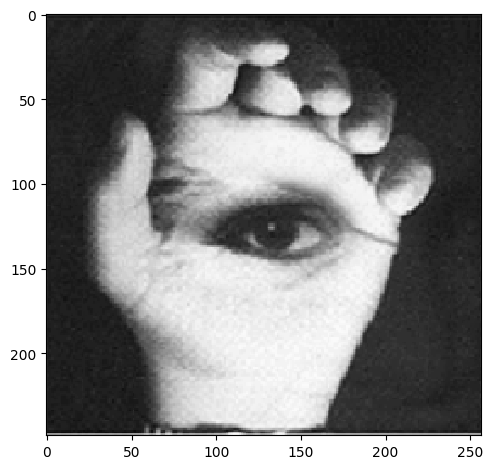

In [48]:
img_out = img_as_ubyte(np.clip(merge(img1, img2, mask, 1, 15), -1, 1))
imshow(img_out)